# Alias/Shadow signals

Assume, you are composing an internal record of some sort that is a little more complex.
Like, a 16 bit wide register with various bit field signals as shown below.

![Register](img/reg_SPI_CONTROL.png)

For a fine grained control of each bit, we would introduce a signal for each bit, but
once the signal goes to a memory mapped register bus, it might have to be one 16 bit word.

We could use the `concat` function explicitely, but a more elegant way could be to use
ConcatSignals. That way, signals update automatically.

See also [Structural modelling](http://docs.myhdl.org/en/stable/manual/structure.html)


..and remember: You can only **read** from a ShadowSignal.

In [1]:
import config

In [2]:
from myhdl import *

@block
def unit(clk, reset, en, group_in, sig_out):

    pump, cpol, cpha, lsbfirst, spics, spireset = [ Signal(bool(0)) for i in range(6) ]
    nbits = Signal(modbv()[5:])
    reserved = Signal(modbv()[5:])

    CPHA = bool(1)
    
    record = ConcatSignal(spireset, spics, reserved, nbits, lsbfirst, CPHA, cpol, pump)
    
    @always(clk.posedge)
    def worker():
        if en:
            spireset.next = False
            nbits.next = group_in.nbits
            pump.next = group_in.pump
            cpol.next = group_in.cpol           
            lsbfirst.next = group_in.lsbfirst           
            spics.next = False
        else:
            spics.next = True

    @always_comb
    def assign():
        sig_out.next = record
        
    return instances()

class Group:
    def __init__(self):
        self.lsbfirst = Signal(bool())
        self.cpol = Signal(bool())
        self.pump = Signal(bool())
        self.nbits = Signal(modbv()[5:])

group_in = Group()
clk, en = [ Signal(bool()) for i in range(2) ]
reset = ResetSignal(0, 1, False)
sig_out = Signal(modbv()[16:])

inst = unit(clk, reset, en, group_in, sig_out)

In [3]:
from myhdl.conversion import yshelper
d = yshelper.Design()
inst.convert("yosys_module", d)

Legacy class group_in
Legacy class group_in
Adding module with name: unit_1_1_1_16
ConcatSignal 'record': 7 signals
Get Concat signal unit_pump
Get Concat signal unit_cpol
Get Concat signal unit_lsbfirst
Get Concat signal unit_nbits
Get Concat signal unit_reserved
Get Concat signal unit_spics
Get Concat signal unit_spireset
CONVERT_RTL tree >>>>>> 'UNIT_WORKER' 
CONVERT_RTL tree >>>>>> 'UNIT_ASSIGN' 


Generating RTL image...
Display...


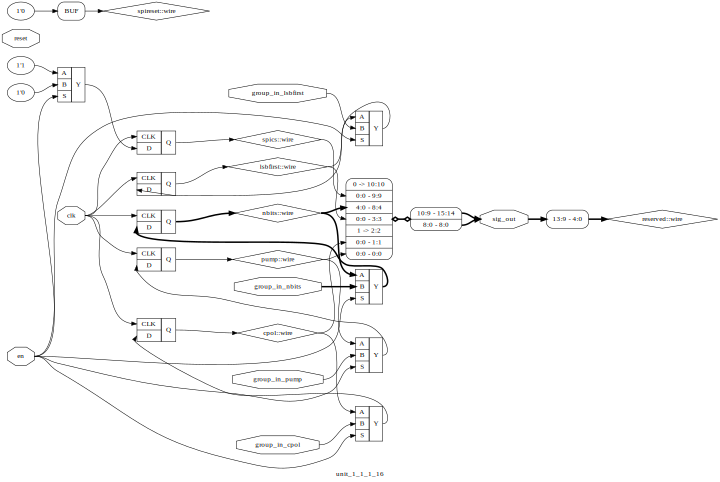

In [4]:
from ys_aux import to_svg
d.run("opt; clean")
display(to_svg(d))

Going the reverse way, i.e. from a **write** word from the bus to the single bit fields is not automatically supported by MyHDL, it requires the auxiliary BusSignal class from the HLS package. However, you can use slice signals as demonstrated below in the [Bit flipping](#Bit-flipping) example.

## Details

Shadow signals are wired at a very early stage, before logic is actually created. This can also come in handy for bit flipping functions.

### Exercise

There is a beauty flaw in the `unit` implementation.

1. What is it? Under what condition could it cause a problem?

   **Describe**

2. Fix the above code

3. Simulate and display waveforms demonstrating that the above condition is covered

## Bit flipping

You might be tempted to try this:

In [5]:
a = intbv(0xa)[8:]
print(bin(a))

b = reversed(a)
print("Reverse:")
for z in b:
    print('1' if z else '0', end = '')

1010
Reverse:
00001010

This may appear as a bug, as the intbv class doesn't support the reversal (in this version).
We try again, showing more coding courage:

In [6]:
from frequently_used import up_counter

@block
def bitflip_test(clk, ce, reset, dout):
    "Bit flip with Slice and ConcatSignal"
    counter = Signal(modbv(0)[8:])
    ctr = up_counter(clk, ce, reset, counter)

    # Create a list of slice signals from the counter bits
    cbits = [ counter(i) for i in range(len(counter)) ]
    # And concatenate them, passing them as argument list using the '*' notation
    data = ConcatSignal(*cbits)

    @always_comb
    def assign():
        dout.next = data

    return instances()

clk, ce = [ Signal(bool()) for i in range(2) ]
reset = ResetSignal(0, 1, False)
dout = Signal(intbv()[8:])

design = yshelper.Design()
inst = bitflip_test(clk, ce, reset, dout)

inst.convert("yosys_module", design)

Adding module with name: up_counter_1_1_1_8
========== Unroll slices for counter/bitflip_test_counter ===========
No ID for slice0, assign 'bitflip_test_counter[0]'
bitflip_test_counter[0]
No ID for slice1, assign 'bitflip_test_counter[1]'
bitflip_test_counter[1]
No ID for slice2, assign 'bitflip_test_counter[2]'
bitflip_test_counter[2]
No ID for slice3, assign 'bitflip_test_counter[3]'
bitflip_test_counter[3]
No ID for slice4, assign 'bitflip_test_counter[4]'
bitflip_test_counter[4]
No ID for slice5, assign 'bitflip_test_counter[5]'
bitflip_test_counter[5]
No ID for slice6, assign 'bitflip_test_counter[6]'
bitflip_test_counter[6]
No ID for slice7, assign 'bitflip_test_counter[7]'
bitflip_test_counter[7]
CONVERT_RTL tree >>>>>> 'BITFLIP_TEST_UP_COUNTER_0_WORKER' 
TRUNC: /home/pyosys/src/myhdl/myhdl-local/example/ipynb/work/myhdl-synthesis/examples/frequently_used.py:17 Implicit carry truncate: counter[8:], src[9:]
Adding module with name: bitflip_test_1_1_1_8
========== Unroll slices f

In [7]:
clk, ce = [ Signal(bool()) for i in range(2) ]
reset = ResetSignal(0, 1, False)
dout = Signal(intbv()[8:])

inst = bitflip_test(clk, ce, reset, dout)

vhdl = inst.convert("vhdl")

Generating RTL image...
Display...


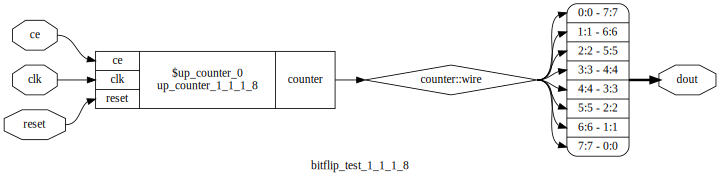

In [8]:
design.run("opt")
display(to_svg(design, "bitflip_test_1_1_1_8"))

As shown, the bit order is reversed, and we remember: MSB comes first in the concatenation.

### More slicing

Likewise, you can use up the `Group` signal class to slice portions out of the 16 bit raw register. This is left as exercise to the user. Hint: A bit field slice portion is taken as follows:

In [9]:
s = Signal(a)
z = s(4, 1)
bin(z)

'101'

# Complex concat/slicing

The following example uses a combination of Shadow Signals to concatenate and slice from a counter signal in order to permutate bits. Here it simply rotates the counter value to the left and to the right and combines them using an XOR gate.

In [10]:
from myhdl import *
from myhdl.conversion import yshelper
from frequently_used import up_counter

@block
def complex_slicing_example(clk, reset, dout, N = 8):
    counter = Signal(intbv()[N:])
    
    inst_counter = up_counter(clk, 1, reset, counter)
    
    sl0 = counter(N-1, 0)
    sl1 = counter(N, 1)
    srol = ConcatSignal(sl0, counter(N-1))
    sror = ConcatSignal(counter(0), sl1)

    @always_comb
    def assign():
        dout.next = srol ^ sror

    return instances()

In [11]:
def complex_slicing(N):

    clk = Signal(bool())
    reset = ResetSignal(0, 1, False)
    dout = Signal(intbv()[N:])

    inst = complex_slicing_example(clk, reset, dout, N)
    d = yshelper.Design("test")
    inst.convert("yosys_module", d)
    
    return d

d = complex_slicing(8)

Adding module with name: up_counter_1_c1_1_8
========== Unroll slices for counter/complex_slicing_example_counter ===========
No ID for slice0, assign 'complex_slicing_example_counter[7:0]'
complex_slicing_example_counter[7:0]
No ID for slice1, assign 'complex_slicing_example_counter[8:1]'
complex_slicing_example_counter[8:1]
No ID for slice2, assign 'complex_slicing_example_counter[7]'
complex_slicing_example_counter[7]
No ID for slice3, assign 'complex_slicing_example_counter[0]'
complex_slicing_example_counter[0]
CONVERT_RTL tree >>>>>> 'COMPLEX_SLICING_EXAMPLE_UP_COUNTER_0_0_1_WORKER' 
TRUNC: /home/pyosys/src/myhdl/myhdl-local/example/ipynb/work/myhdl-synthesis/examples/frequently_used.py:17 Implicit carry truncate: counter[8:], src[9:]
Adding module with name: complex_slicing_example_1_1_8_c8
========== Unroll slices for s/complex_slicing_example_s ===========
No ID for slice0, assign 'complex_slicing_example_s[4:1]'
complex_slicing_example_s[4:1]
========== Unroll slices for coun

Generating RTL image...
Display...


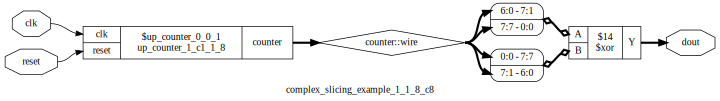

In [12]:
from ys_aux import to_svg
d.run("opt")
display(to_svg(d))

In [13]:
clk = Signal(bool())
reset = ResetSignal(0, 1, False)
dout = Signal(intbv()[8:])

inst = complex_slicing_example(clk, reset, dout)
x = inst.convert("vhdl", d)

Download [complex_slicing_example.vhd](complex_slicing_example.vhd)